# Aula Prática: Hugging Face - Do Básico ao Avançado

## Objetivo da Aula
Esta aula aborda desde os conceitos fundamentais de processamento de linguagem natural com Hugging Face até técnicas avançadas como quantização e geração de texto com modelos grandes.


---

## Introdução ao Hugging Face

O Hugging Face é uma plataforma que democratiza o acesso a modelos de Machine Learning, especialmente para NLP. Oferece:

- **Transformers**: Biblioteca com modelos pré-treinados
- **Hub**: Repositório de modelos, datasets e spaces
- **Tokenizers**: Processamento eficiente de texto
- **Datasets**: Biblioteca para manipulação de dados

### Instalação das Bibliotecas Necessárias

In [2]:
# Instalação das bibliotecas necessárias
!pip install transformers  datasets tokenizers accelerate bitsandbytes
# torch torchvision torchaudio scipy matplotlib pandas scikit-learn ipykernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.3 MB/s eta 0:00:00


In [3]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForMaskedLM,
    AutoModelForCausalLM, BitsAndBytesConfig, pipeline
)
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.8.0+cu126
Device: CUDA
GPU: Tesla T4
CUDA Memory: 15.8 GB


## Tokenização - A Base do Processamento de Texto

A tokenização é o processo de converter texto em tokens (unidades menores) que o modelo pode entender. Existem diferentes estratégias:

### 2.1 Tipos de Tokenização
1. **[Word-level](https://youtu.be/nhJxYji1aho)**: Divide por palavras
    - Fácil de entender, porém o vocabulário cresce enormemente e não lida bem com erros de digitação.
2. **[Character-level](https://youtu.be/ssLq_EK2jLE)**: Divide por caracteres  
    - Vocabulário pequeno e funciona bem em qualquer idioma, porém gera sequencias muito longas e, consequentemente, modelos mais lentos.
3. **[Subword](https://youtu.be/zHvTiHr506c)**: Divide em subpalvras (BPE, WordPiece, SentencePiece)
    - Palavras mais comuns costumam ficar inteiras e palavras menos comuns são quebradas em "partes conhecidas" criando um vocabulário mais compacto que funciona bem para vários idiomas, porém os tokens não são tão intuitvos para humanos.

### 2.2 Tokenização na Prática

In [4]:
# Exemplo prático de tokenização com diferentes modelos

# Texto para demonstração
texto = "Olá! Meu nome é Lívia e estou aprendendo sobre transformers no Hugging Face."

# 1. Tokenizador BERT (WordPiece)
print("=== TOKENIZAÇÃO COM BERT ===")
tokenizer_bert = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Tokenização básica
tokens_bert = tokenizer_bert.tokenize(texto)
print(f"Tokens BERT: {tokens_bert}")
print(f"Número de tokens: {len(tokens_bert)}")

# Codificação completa (com IDs)
encoded_bert = tokenizer_bert(texto, return_tensors='pt')
print(f"Input IDs: {encoded_bert['input_ids']}")
print(f"Attention Mask: {encoded_bert['attention_mask']}")

# Decodificação
decoded_bert = tokenizer_bert.decode(encoded_bert['input_ids'][0])
print(f"Texto decodificado: {decoded_bert}")

print("\n" + "="*60 + "\n")

=== TOKENIZAÇÃO COM BERT ===


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokens BERT: ['Ol', '##á', '!', 'Meu', 'nome', 'é', 'Lí', '##via', 'e', 'estou', 'aprend', '##endo', 'sobre', 'transform', '##ers', 'no', 'Hu', '##gg', '##ing', 'Face', '.']
Número de tokens: 21
Input IDs: tensor([[  101,  1651, 22303,   106, 18153,   655,   253, 12236,   619,   122,
         12044,  6411,  1825,   498,  5741,   424,   202,  3222,  9704,   446,
         10458,   119,   102]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Texto decodificado: [CLS] Olá! Meu nome é Lívia e estou aprendendo sobre transformers no Hugging Face. [SEP]




In [5]:
# 2. Tokenizador GPT-2 (BPE)
print("=== TOKENIZAÇÃO COM GPT-2 ===")
tokenizer_gpt2 = AutoTokenizer.from_pretrained('gpt2')

# Configurar pad_token para GPT-2
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

tokens_gpt2 = tokenizer_gpt2.tokenize(texto)
print(f"Tokens GPT-2: {tokens_gpt2}")
print(f"Número de tokens: {len(tokens_gpt2)}")

encoded_gpt2 = tokenizer_gpt2(texto, return_tensors='pt')
print(f"Input IDs: {encoded_gpt2['input_ids']}")

decoded_gpt2 = tokenizer_gpt2.decode(encoded_gpt2['input_ids'][0])
print(f"Texto decodificado: {decoded_gpt2}")

print("\n" + "="*60 + "\n")

# Comparação visual dos tokens
import pandas as pd

# Determinar o tamanho máximo para alinhar os arrays
max_len = max(len(tokens_bert), len(tokens_gpt2))

# Criar arrays do mesmo tamanho preenchendo com None
bert_padded = tokens_bert + [None] * (max_len - len(tokens_bert))
gpt2_padded = tokens_gpt2 + [None] * (max_len - len(tokens_gpt2))

df_comparison = pd.DataFrame({
    'Token_Index': range(max_len),
    'BERT_Tokens': bert_padded,
    'GPT2_Tokens': gpt2_padded
})

print("=== COMPARAÇÃO DE TOKENIZAÇÃO ===")
print(df_comparison.to_string(index=False))

=== TOKENIZAÇÃO COM GPT-2 ===


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokens GPT-2: ['Ol', 'Ã¡', '!', 'ĠMe', 'u', 'Ġn', 'ome', 'ĠÃ©', 'ĠL', 'ÃŃ', 'via', 'Ġe', 'Ġest', 'ou', 'Ġap', 'rend', 'endo', 'Ġso', 'bre', 'Ġtransform', 'ers', 'Ġno', 'ĠHug', 'ging', 'ĠFace', '.']
Número de tokens: 26
Input IDs: tensor([[30098,  6557,     0,  2185,    84,   299,   462, 38251,   406,  8836,
          8869,   304,  1556,   280,  2471, 10920, 31110,   523,  4679,  6121,
           364,   645, 12905,  2667, 15399,    13]])
Texto decodificado: Olá! Meu nome é Lívia e estou aprendendo sobre transformers no Hugging Face.


=== COMPARAÇÃO DE TOKENIZAÇÃO ===
 Token_Index BERT_Tokens GPT2_Tokens
           0          Ol          Ol
           1         ##á          Ã¡
           2           !           !
           3         Meu         ĠMe
           4        nome           u
           5           é          Ġn
           6          Lí         ome
           7       ##via         ĠÃ©
           8           e          ĠL
           9       estou          ÃŃ
          10      a

## Arquitetura Transformer - Como Funciona

O Transformer é a arquitetura revolucionária por trás dos modelos modernos de NLP. Vamos entender seus componentes principais:

### Componentes Principais:
- **Self-Attention**: Mecanismo que permite ao modelo focar em diferentes partes da entrada
- **Multi-Head Attention**: Múltiplas "cabeças" de atenção paralelas
- **Feed Forward Networks**: Redes neurais densas
- **Layer Normalization**: Normalização para estabilidade do treino
- **Positional Encoding**: Informação sobre posição dos tokens

Vídeos recomendados (do 3b1b):
1. [Transformers](https://youtu.be/wjZofJX0v4M)
2. [Atenção](https://youtu.be/eMlx5fFNoYc)

### Tipos de Transformer:
- [**Encoder-only**](https://www.youtube.com/watch?v=MUqNwgPjJvQ): BERT (bidirecional)
- [*Decoder-only**](https://www.youtube.com/watch?v=d_ixlCubqQw): GPT (unidirecional)
- [**Encoder-Decoder**](https://www.youtube.com/watch?v=0_4KEb08xrE&t=228s): T5, BART (seq2seq)

In [6]:
# Visualização da Arquitetura Transformer

def analisar_arquitetura_modelo():
    # Carregar um modelo BERT pequeno para análise
    model_name = 'neuralmind/bert-base-portuguese-cased'
    model = AutoModel.from_pretrained(model_name)

    print("=== ANÁLISE DA ARQUITETURA TRANSFORMER ===")
    print(f"Modelo: {model_name}")
    print(f"Número total de parâmetros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Configuração do modelo
    config = model.config
    print(f"\n=== CONFIGURAÇÃO DO MODELO ===")
    print(f"Dimensão do modelo (hidden_size): {config.hidden_size}")
    print(f"Número de camadas: {config.num_hidden_layers}")
    print(f"Número de cabeças de atenção: {config.num_attention_heads}")
    print(f"Dimensão intermediária (FFN): {config.intermediate_size}")
    print(f"Tamanho do vocabulário: {config.vocab_size}")
    print(f"Tamanho máximo da sequência: {config.max_position_embeddings}")

    # Estrutura das camadas
    print(f"\n=== ESTRUTURA DAS CAMADAS ===")
    for name, module in model.named_children():
        print(f"- {name}: {type(module).__name__}")
        if hasattr(module, '__len__'):
            try:
                print(f"  └── Contém {len(module)} subcamadas")
            except:
                pass

    return model, config

modelo, config = analisar_arquitetura_modelo()

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

=== ANÁLISE DA ARQUITETURA TRANSFORMER ===
Modelo: neuralmind/bert-base-portuguese-cased
Número total de parâmetros: 108,923,136
Parâmetros treináveis: 108,923,136

=== CONFIGURAÇÃO DO MODELO ===
Dimensão do modelo (hidden_size): 768
Número de camadas: 12
Número de cabeças de atenção: 12
Dimensão intermediária (FFN): 3072
Tamanho do vocabulário: 29794
Tamanho máximo da sequência: 512

=== ESTRUTURA DAS CAMADAS ===
- embeddings: BertEmbeddings
- encoder: BertEncoder
- pooler: BertPooler


🔍 COMPARAÇÃO: ATENÇÃO COM E SEM TOKENS ESPECIAIS

1️⃣ PRIMEIRA VISUALIZAÇÃO: COM TOKENS ESPECIAIS ([CLS] e [SEP])


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


=== PESOS DE ATENÇÃO COM TOKENS ESPECIAIS ===
Texto original: O gato subiu no telhado da casa
Tokens completos: ['[CLS]', 'O', 'gato', 'subiu', 'no', 'telhado', 'da', 'casa', '[SEP]']
Forma da matriz de atenção: (9, 9)


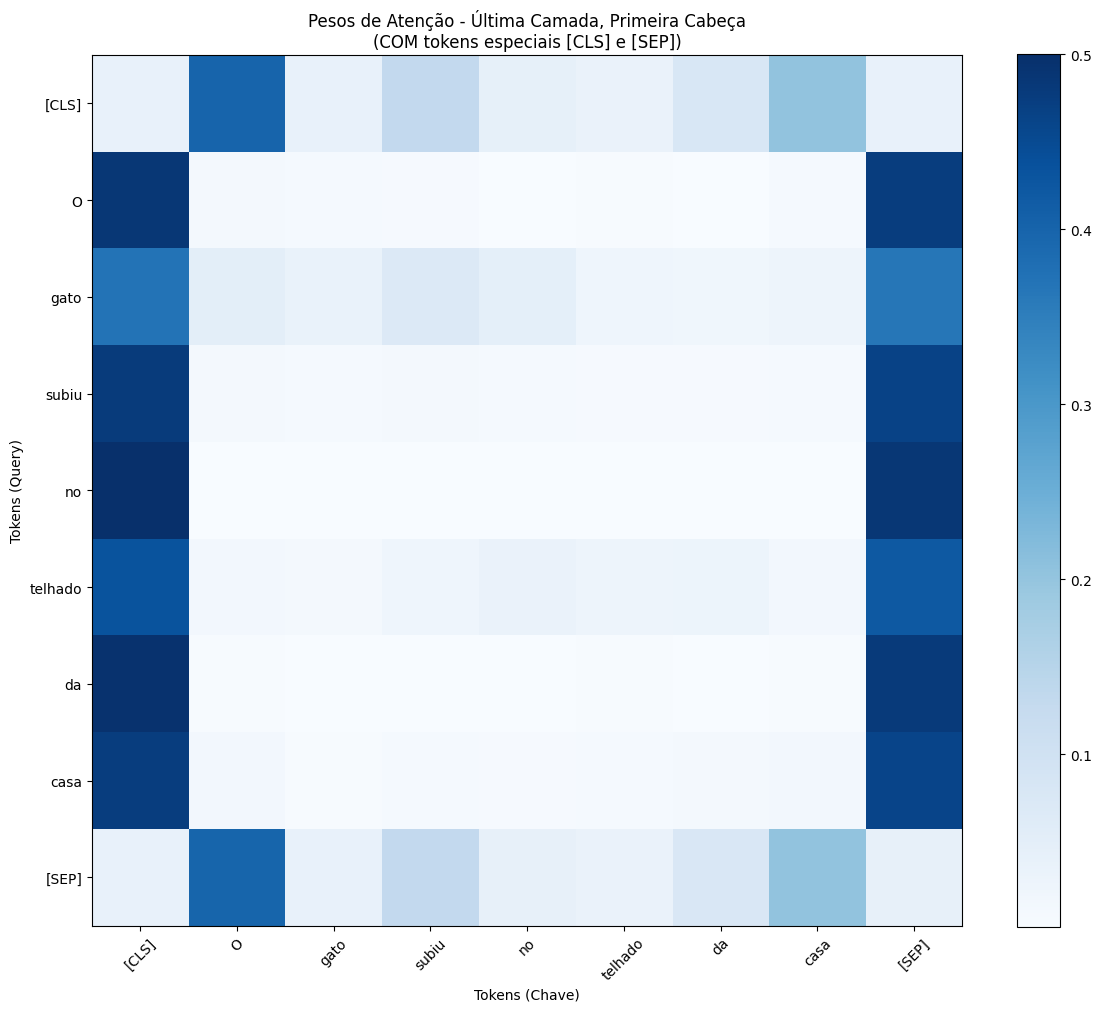


=== ANÁLISE DOS PESOS DE ATENÇÃO (COM TOKENS ESPECIAIS) ===
'[CLS]' presta mais atenção em 'O' (peso: 0.3996)
'O' presta mais atenção em '[CLS]' (peso: 0.4856)
'gato' presta mais atenção em '[CLS]' (peso: 0.3699)
'subiu' presta mais atenção em '[CLS]' (peso: 0.4774)
'no' presta mais atenção em '[CLS]' (peso: 0.5003)
'telhado' presta mais atenção em '[CLS]' (peso: 0.4333)
'da' presta mais atenção em '[CLS]' (peso: 0.4963)
'casa' presta mais atenção em '[CLS]' (peso: 0.4742)
'[SEP]' presta mais atenção em 'O' (peso: 0.3984)


2️⃣ SEGUNDA VISUALIZAÇÃO: SEM TOKENS ESPECIAIS (APENAS FRASE)
=== PESOS DE ATENÇÃO SEM TOKENS ESPECIAIS ===
Texto original: O gato subiu no telhado da casa
Tokens da frase (sem especiais): ['O', 'gato', 'subiu', 'no', 'telhado', 'da', 'casa']
Forma da matriz de atenção da frase: (7, 7)


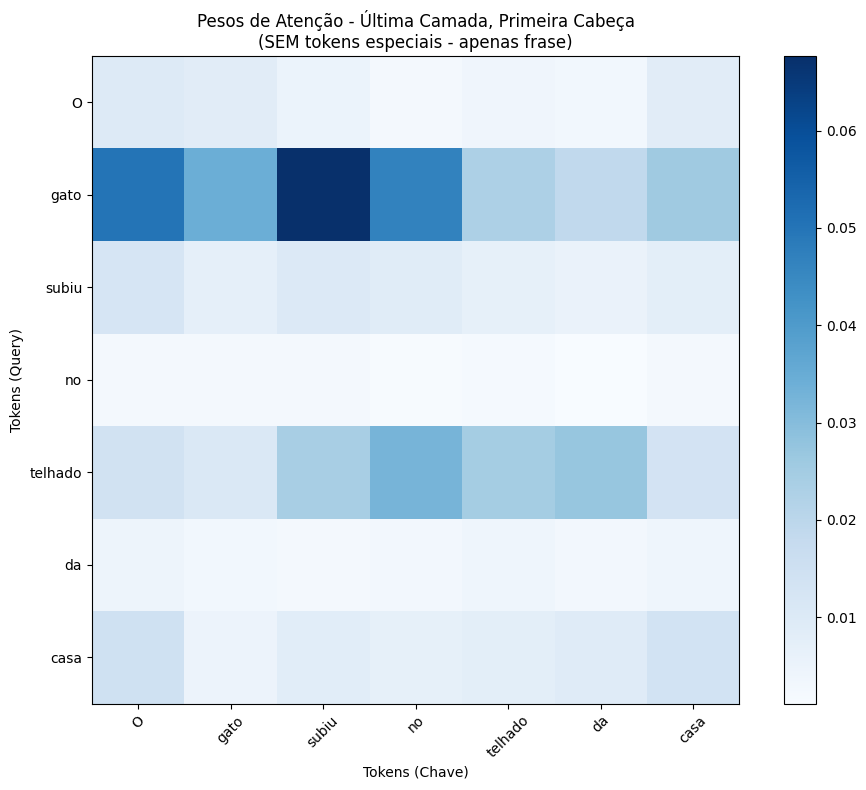


=== ANÁLISE DOS PESOS DE ATENÇÃO (SEM TOKENS ESPECIAIS) ===
'O' presta mais atenção em 'O' (peso: 0.0098)
'gato' presta mais atenção em 'subiu' (peso: 0.0676)
'subiu' presta mais atenção em 'O' (peso: 0.0123)
'no' presta mais atenção em 'gato' (peso: 0.0026)
'telhado' presta mais atenção em 'no' (peso: 0.0324)
'da' presta mais atenção em 'O' (peso: 0.0043)
'casa' presta mais atenção em 'O' (peso: 0.0145)

💡 Compare as duas visualizações para entender como os tokens especiais
   influenciam os padrões de atenção do modelo!


In [9]:
# Demonstração do Mecanismo de Atenção

def visualizar_attention_weights_completo():
    """
    Visualiza pesos de atenção COM tokens especiais ([CLS] e [SEP])
    """
    # Texto para análise
    texto = "O gato subiu no telhado da casa"

    tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

    # Tokenizar
    inputs = tokenizer(texto, return_tensors='pt')

    # Obter outputs com attention weights
    with torch.no_grad():
        outputs = modelo(inputs['input_ids'],
                        attention_mask=inputs['attention_mask'],
                        output_attentions=True)

    # Pegar attention weights da última camada, primeira cabeça
    attention_weights = outputs.attentions[-1][0, 0].numpy()  # [seq_len, seq_len]

    # Tokens para visualização (TODOS os tokens incluindo especiais)
    all_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    print("=== PESOS DE ATENÇÃO COM TOKENS ESPECIAIS ===")
    print(f"Texto original: {texto}")
    print(f"Tokens completos: {all_tokens}")
    print(f"Forma da matriz de atenção: {attention_weights.shape}")

    # Visualização da atenção completa (com tokens especiais)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 10))
    plt.imshow(attention_weights, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.title('Pesos de Atenção - Última Camada, Primeira Cabeça\n(COM tokens especiais [CLS] e [SEP])')
    plt.xlabel('Tokens (Chave)')
    plt.ylabel('Tokens (Query)')
    plt.xticks(range(len(all_tokens)), all_tokens, rotation=45)
    plt.yticks(range(len(all_tokens)), all_tokens)
    plt.tight_layout()
    plt.show()

    # Análise dos pesos mais altos (todos os tokens)
    print(f"\n=== ANÁLISE DOS PESOS DE ATENÇÃO (COM TOKENS ESPECIAIS) ===")
    for i, token_query in enumerate(all_tokens):
        max_attention_idx = attention_weights[i].argmax()
        max_attention_value = attention_weights[i].max()
        print(f"'{token_query}' presta mais atenção em '{all_tokens[max_attention_idx]}' (peso: {max_attention_value:.4f})")

def visualizar_attention_weights_sem_especiais():
    """
    Visualiza pesos de atenção SEM tokens especiais (apenas tokens da frase)
    """
    tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')


    # Texto para análise
    texto = "O gato subiu no telhado da casa"

    # Tokenizar
    inputs = tokenizer(texto, return_tensors='pt')

    # Obter outputs com attention weights
    with torch.no_grad():
        outputs = modelo(inputs['input_ids'],
                        attention_mask=inputs['attention_mask'],
                        output_attentions=True)

    # Pegar attention weights da última camada, primeira cabeça
    attention_weights = outputs.attentions[-1][0, 0].numpy()  # [seq_len, seq_len]

    # Tokens para visualização (todos os tokens incluindo especiais)
    all_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Remover tokens especiais ([CLS] e [SEP]) da visualização
    # Identificar índices dos tokens especiais
    start_idx = 1 if all_tokens[0] == '[CLS]' else 0
    end_idx = len(all_tokens) - 1 if all_tokens[-1] == '[SEP]' else len(all_tokens)

    # Extrair apenas os tokens da frase (sem [CLS] e [SEP])
    tokens = all_tokens[start_idx:end_idx]

    # Extrair a submatriz correspondente aos tokens da frase
    attention_subset = attention_weights[start_idx:end_idx, start_idx:end_idx]

    print("=== PESOS DE ATENÇÃO SEM TOKENS ESPECIAIS ===")
    print(f"Texto original: {texto}")
    print(f"Tokens da frase (sem especiais): {tokens}")
    print(f"Forma da matriz de atenção da frase: {attention_subset.shape}")

    # Visualização da atenção (apenas tokens da frase)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    plt.imshow(attention_subset, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.title('Pesos de Atenção - Última Camada, Primeira Cabeça\n(SEM tokens especiais - apenas frase)')
    plt.xlabel('Tokens (Chave)')
    plt.ylabel('Tokens (Query)')
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.yticks(range(len(tokens)), tokens)
    plt.tight_layout()
    plt.show()

    # Análise dos pesos mais altos (apenas para tokens da frase)
    print(f"\n=== ANÁLISE DOS PESOS DE ATENÇÃO (SEM TOKENS ESPECIAIS) ===")
    for i, token_query in enumerate(tokens):
        max_attention_idx = attention_subset[i].argmax()
        max_attention_value = attention_subset[i].max()
        print(f"'{token_query}' presta mais atenção em '{tokens[max_attention_idx]}' (peso: {max_attention_value:.4f})")

# Executar ambas as visualizações para comparação
print("🔍 COMPARAÇÃO: ATENÇÃO COM E SEM TOKENS ESPECIAIS")
print("=" * 70)

print("\n1️⃣ PRIMEIRA VISUALIZAÇÃO: COM TOKENS ESPECIAIS ([CLS] e [SEP])")
visualizar_attention_weights_completo()

print("\n" + "="*70 + "\n")

print("2️⃣ SEGUNDA VISUALIZAÇÃO: SEM TOKENS ESPECIAIS (APENAS FRASE)")
visualizar_attention_weights_sem_especiais()

print("\n" + "="*70)
print("💡 Compare as duas visualizações para entender como os tokens especiais")
print("   influenciam os padrões de atenção do modelo!")
print("="*70)

## Modelos Iniciais e Pipelines - Uso Prático

O Hugging Face oferece pipelines prontos para várias tarefas de NLP. Vamos explorar os principais:

### 5.1 Principais Pipelines:
- **sentiment-analysis**: Análise de sentimentos
- **text-classification**: Classificação de texto
- **token-classification**: Reconhecimento de entidades (NER)
- **question-answering**: Resposta a perguntas
- **text-generation**: Geração de texto
- **summarization**: Sumarização
- **translation**: Tradução

In [10]:
# Demonstração de Diferentes Pipelines

# 1. Análise de Sentimentos
print("=== 1. ANÁLISE DE SENTIMENTOS ===")
try:
    # Primeiro tenta um modelo mais compatível
    sentiment_pipeline = pipeline("sentiment-analysis",
                                model="nlptown/bert-base-multilingual-uncased-sentiment")

    textos_sentimento = [
        "Eu amo programar em Python!",
        "Este código está muito confuso e difícil.",
        "O novo modelo funciona razoavelmente bem."
    ]

    for texto in textos_sentimento:
        resultado = sentiment_pipeline(texto)
        print(f"Texto: '{texto}'")
        print(f"Sentimento: {resultado[0]['label']} (confiança: {resultado[0]['score']:.4f})")
        print("-" * 50)

except Exception as e:
    print(f"Erro com modelo multilingual: {e}")
    print("Tentando modelo padrão em inglês...")
    try:
        # Fallback para modelo padrão
        sentiment_pipeline = pipeline("sentiment-analysis")

        textos_sentimento = [
            "I love programming in Python!",
            "This code is very confusing and difficult.",
            "The new model works reasonably well."
        ]

        for texto in textos_sentimento:
            resultado = sentiment_pipeline(texto)
            print(f"Texto: '{texto}'")
            print(f"Sentimento: {resultado[0]['label']} (confiança: {resultado[0]['score']:.4f})")
            print("-" * 50)

    except Exception as e2:
        print(f"Erro na análise de sentimentos: {e2}")
        print("💡 Pulando análise de sentimentos por problemas de compatibilidade")

print("\n" + "="*60 + "\n")

=== 1. ANÁLISE DE SENTIMENTOS ===


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Texto: 'Eu amo programar em Python!'
Sentimento: 5 stars (confiança: 0.4085)
--------------------------------------------------
Texto: 'Este código está muito confuso e difícil.'
Sentimento: 1 star (confiança: 0.4327)
--------------------------------------------------
Texto: 'O novo modelo funciona razoavelmente bem.'
Sentimento: 4 stars (confiança: 0.4113)
--------------------------------------------------




In [11]:
# 2. Reconhecimento de Entidades Nomeadas (NER)
print("=== 2. RECONHECIMENTO DE ENTIDADES NOMEADAS ===")
try:
    ner_pipeline = pipeline("token-classification",
                           model="pierreguillou/ner-bert-base-cased-pt-lenerbr",
                           aggregation_strategy="simple")

    texto_ner = "João Silva trabalha na empresa Microsoft no RJ desde 2020."

    entidades = ner_pipeline(texto_ner)

    print(f"Texto: {texto_ner}")
    print("\nEntidades encontradas:")
    for entidade in entidades:
        print(f"- {entidade['word']}: {entidade['entity_group']} (confiança: {entidade['score']:.4f})")

except Exception as e:
    print(f"Erro no NER: {e}")

print("\n" + "="*60 + "\n")

=== 2. RECONHECIMENTO DE ENTIDADES NOMEADAS ===


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Texto: João Silva trabalha na empresa Microsoft no RJ desde 2020.

Entidades encontradas:
- João Silva: PESSOA (confiança: 0.9997)
- Microsoft: ORGANIZACAO (confiança: 0.9984)
- RJ: LOCAL (confiança: 0.9191)
- 202: TEMPO (confiança: 0.9965)
- ##0: TEMPO (confiança: 0.9913)




In [12]:
# 3. Question Answering
print("=== 3. SISTEMA DE PERGUNTAS E RESPOSTAS ===")
try:
    qa_pipeline = pipeline("question-answering",
                          model="pierreguillou/bert-base-cased-squad-v1.1-portuguese")

    contexto = """
    O Python é uma linguagem de programação de alto nível, interpretada e de propósito geral.
    Foi criada por Guido van Rossum e lançada pela primeira vez em 1991.
    Python é conhecida por sua sintaxe limpa e legível, tornando-a uma excelente escolha
    para iniciantes em programação. É amplamente usada em ciência de dados, desenvolvimento web,
    automação e inteligência artificial.
    """

    perguntas = [
        "Quem criou o Python?",
        "Em que ano foi lançado o Python?",
        "Para que é usado o Python?"
    ]

    print(f"Contexto: {contexto.strip()}")
    print("\n" + "-"*60 + "\n")

    for pergunta in perguntas:
        resultado = qa_pipeline(question=pergunta, context=contexto)
        print(f"Pergunta: {pergunta}")
        print(f"Resposta: {resultado['answer']}")
        print(f"Confiança: {resultado['score']:.4f}")
        print("-" * 40)

except Exception as e:
    print(f"Erro no QA: {e}")

print("\n" + "="*60 + "\n")

=== 3. SISTEMA DE PERGUNTAS E RESPOSTAS ===


config.json:   0%|          | 0.00/862 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/494 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Contexto: O Python é uma linguagem de programação de alto nível, interpretada e de propósito geral.
    Foi criada por Guido van Rossum e lançada pela primeira vez em 1991.
    Python é conhecida por sua sintaxe limpa e legível, tornando-a uma excelente escolha
    para iniciantes em programação. É amplamente usada em ciência de dados, desenvolvimento web,
    automação e inteligência artificial.

------------------------------------------------------------

Pergunta: Quem criou o Python?
Resposta: Guido van Rossum
Confiança: 0.9991
----------------------------------------
Pergunta: Em que ano foi lançado o Python?
Resposta: 1991
Confiança: 0.9932
----------------------------------------
Pergunta: Para que é usado o Python?
Resposta: ciência de dados, desenvolvimento web,
    automação e inteligência artificial
Confiança: 0.6142
----------------------------------------




## Fine-tuning

Fine-tuning é o processo de adaptar um modelo pré-treinado para uma tarefa específica. Vamos demonstrar um exemplo básico:

### 6.1 Processo de Fine-tuning:
1. **Preparação dos dados**: Formatação adequada
2. **Configuração do modelo**: Ajuste da cabeça de classificação
3. **Treinamento**: Otimização com taxa de aprendizado baixa
4. **Avaliação**: Métricas de performance
5. **Inferência**: Uso do modelo ajustado

Se você quiser fazer um fine tuning, aqui está um exemplo usando a biblioteca Hugging Face: https://huggingface.co/learn/llm-course/en/chapter3/3


## Quantização de Modelos - Otimizando para Produção

Quantização é uma técnica para reduzir o tamanho do modelo e acelerar a inferência, convertendo pesos de ponto flutuante para formatos mais compactos (ex: int8, int4).

In [ ]:
# Demonstração de Quantização

def demonstrar_quantizacao():
    print("=== DEMONSTRAÇÃO DE QUANTIZAÇÃO ===")

    # Configuração de quantização 4-bit
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,                    # Usar quantização 4-bit
        bnb_4bit_quant_type="nf4",           # Tipo de quantização normal float 4
        bnb_4bit_compute_dtype=torch.float16, # Tipo de dados para computação
        bnb_4bit_use_double_quant=True,      # Quantização dupla para melhor compressão
    )

    print("Configuração de quantização 4-bit:")
    print(f"- Tipo de quantização: {quantization_config.bnb_4bit_quant_type}")
    print(f"- Tipo de computação: {quantization_config.bnb_4bit_compute_dtype}")
    print(f"- Quantização dupla: {quantization_config.bnb_4bit_use_double_quant}")

    # Comparação de memória (simulada)
    modelo_original_mb = 500  # MB (exemplo)
    modelo_4bit_mb = modelo_original_mb / 4  # Aproximadamente 4x menor
    modelo_8bit_mb = modelo_original_mb / 2  # Aproximadamente 2x menor

    print(f"\n=== COMPARAÇÃO DE TAMANHO ===")
    print(f"Modelo original (FP32): ~{modelo_original_mb} MB")
    print(f"Modelo 8-bit: ~{modelo_8bit_mb} MB ({modelo_original_mb/modelo_8bit_mb:.1f}x menor)")
    print(f"Modelo 4-bit: ~{modelo_4bit_mb} MB ({modelo_original_mb/modelo_4bit_mb:.1f}x menor)")

    # Demonstrar diferentes tipos de quantização
    print(f"\n=== TIPOS DE QUANTIZAÇÃO ===")
    tipos_quant = {
        "FP32": "Float 32-bit (padrão)",
        "FP16": "Float 16-bit (half precision)",
        "INT8": "Integer 8-bit",
        "INT4": "Integer 4-bit",
        "NF4": "Normal Float 4-bit (otimizado)"
    }

    for tipo, descricao in tipos_quant.items():
        print(f"- {tipo}: {descricao}")

    return quantization_config

config_quantizacao = demonstrar_quantizacao()

=== DEMONSTRAÇÃO DE QUANTIZAÇÃO ===
Configuração de quantização 4-bit:
- Tipo de quantização: nf4
- Tipo de computação: torch.float16
- Quantização dupla: True

=== COMPARAÇÃO DE TAMANHO ===
Modelo original (FP32): ~500 MB
Modelo 8-bit: ~250.0 MB (2.0x menor)
Modelo 4-bit: ~125.0 MB (4.0x menor)

=== TIPOS DE QUANTIZAÇÃO ===
- FP32: Float 32-bit (padrão)
- FP16: Float 16-bit (half precision)
- INT8: Integer 8-bit
- INT4: Integer 4-bit
- NF4: Normal Float 4-bit (otimizado)


## Geração de Texto com Qwen3-4B

Agora vamos usar o modelo Qwen3-4B para geração de texto avançada. Este é um modelo de linguagem grande (LLM) capaz de gerar texto contextual de alta qualidade.

### Sobre o Qwen3-4B:
- **Parâmetros**: 4 bilhões
- **Arquitetura**: Transformer decoder-only
- **Linguagens**: Multilingual (incluindo português)
- **Tarefas**: Geração de texto, conversação, código

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen3-4B-Instruct-2507"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

# prepare the model input
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=16384
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

content = tokenizer.decode(output_ids, skip_special_tokens=True)

print("content:", content)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

In [ ]:
# Carregamento e uso do Qwen3-4B

def configurar_qwen():
    """
    Configura e carrega o modelo Qwen3-4B com quantização para economia de memória
    """
    print("=== CONFIGURANDO QWEN3-4B ===")

    model_name = "Qwen/Qwen3-4B-Instruct-2507"

    # Configuração de quantização para economia de memória
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )

    try:
        # Carregar tokenizador
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        print(f"✓ Tokenizador carregado: {model_name}")
        print(f"  - Vocabulário: {len(tokenizer)} tokens")
        print(f"  - Token especiais: EOS='{tokenizer.eos_token}', BOS='{tokenizer.bos_token}'")

        # Carregar modelo com quantização
        if torch.cuda.is_available():
            print("✓ GPU detectada - carregando modelo quantizado...")
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                quantization_config=quantization_config,
                device_map="auto",
                torch_dtype=torch.float16,
                trust_remote_code=True
            )
        else:
            print("⚠ CPU apenas - carregando modelo em precisão reduzida...")
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16,
                trust_remote_code=True,
                device_map="cpu"
            )

        print(f"✓ Modelo carregado com sucesso!")

        # Verificar parâmetros
        num_params = sum(p.numel() for p in model.parameters())
        print(f"  - Parâmetros totais: {num_params:,}")

        return model, tokenizer

    except Exception as e:
        print(f"❌ Erro ao carregar modelo: {e}")
        print("💡 Tentando modelo alternativo menor...")

        # Modelo alternativo menor
        alt_model_name = "microsoft/DialoGPT-medium"
        tokenizer = AutoTokenizer.from_pretrained(alt_model_name)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(alt_model_name)
        print(f"✓ Modelo alternativo carregado: {alt_model_name}")

        return model, tokenizer

# Carregar o modelo
modelo_qwen, tokenizer_qwen = configurar_qwen()

=== CONFIGURANDO QWEN3-4B ===


`torch_dtype` is deprecated! Use `dtype` instead!


✓ Tokenizador carregado: Qwen/Qwen3-4B-Instruct-2507
  - Vocabulário: 151669 tokens
  - Token especiais: EOS='<|im_end|>', BOS='None'
✓ GPU detectada - carregando modelo quantizado...


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]



✓ Modelo carregado com sucesso!
  - Parâmetros totais: 2,205,810,176


In [ ]:
# Funções para geração de texto

def gerar_texto_avancado(prompt, max_length=200, temperature=0.7, top_p=0.9, top_k=50):
    """
    Gera texto usando o modelo carregado com parâmetros configuráveis
    """
    print(f"🤖 Gerando resposta para: '{prompt}'")
    print(f"📊 Parâmetros: temp={temperature}, top_p={top_p}, top_k={top_k}, max_len={max_length}")
    print("-" * 60)

    # Formatar prompt para modelos de instrução
    if "Qwen" in str(type(modelo_qwen)):
        formatted_prompt = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"
    else:
        formatted_prompt = prompt

    # Tokenizar
    inputs = tokenizer_qwen(formatted_prompt, return_tensors="pt")

    if torch.cuda.is_available() and next(modelo_qwen.parameters()).is_cuda:
        inputs = {k: v.to(modelo_qwen.device) for k, v in inputs.items()}

    # Gerar
    with torch.no_grad():
        outputs = modelo_qwen.generate(
            inputs["input_ids"],
            max_length=inputs["input_ids"].shape[1] + max_length,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            do_sample=True,
            pad_token_id=tokenizer_qwen.pad_token_id,
            eos_token_id=tokenizer_qwen.eos_token_id,
            repetition_penalty=1.1
        )

    # Decodificar apenas o texto gerado (sem o prompt)
    generated_text = tokenizer_qwen.decode(
        outputs[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    ).strip()

    print(f"📝 Resposta gerada:\n{generated_text}")
    return generated_text

# Exemplos de geração de texto
prompts_exemplo = [
    "Explique o que são redes neurais de forma simples:",
    "Escreva um pequeno poema sobre inteligência artificial:",
    "Quais são as principais aplicações do machine learning?",
    "Como funciona o algoritmo de backpropagation?"
]

print("=== DEMONSTRAÇÕES DE GERAÇÃO DE TEXTO ===\n")

for i, prompt in enumerate(prompts_exemplo[:2], 1):  # Apenas os primeiros 2 para não sobrecarregar
    print(f"Exemplo {i}:")
    try:
        resultado = gerar_texto_avancado(prompt, max_length=150, temperature=0.7)
        print("\n" + "="*80 + "\n")
    except Exception as e:
        print(f"❌ Erro na geração: {e}\n")
        print("="*80 + "\n")

=== DEMONSTRAÇÕES DE GERAÇÃO DE TEXTO ===

Exemplo 1:
🤖 Gerando resposta para: 'Explique o que são redes neurais de forma simples:'
📊 Parâmetros: temp=0.7, top_p=0.9, top_k=50, max_len=150
------------------------------------------------------------
📝 Resposta gerada:
Claro! Vamos explicar **redes neurais** de forma simples, como se estivéssemos conversando com um amigo.

---

### 🌟 O que são redes neurais?

Imagine que você tem uma caixa mágica. Quando você coloca algo dentro dela (por exemplo, uma foto), ela consegue prever o que está nessa foto — como se fosse um cachorro, uma pessoa ou um carro.

Agora, pense nessa caixa como um "cérebro artificial". A rede neural é uma maneira de construir esse cérebro usando computadores.

---

### 💡 Como funciona?

1. **Ela aprende como um cérebro humano**


Exemplo 2:
🤖 Gerando resposta para: 'Escreva um pequeno poema sobre inteligência artificial:'
📊 Parâmetros: temp=0.7, top_p=0.9, top_k=50, max_len=150
---------------------------------------

In [ ]:
# Análise de Parâmetros de Geração

def comparar_parametros_geracao():
    """
    Demonstra como diferentes parâmetros afetam a geração de texto
    """
    print("=== IMPACTO DOS PARÂMETROS DE GERAÇÃO ===")

    prompt_teste = "O futuro da inteligência artificial é"

    # Diferentes configurações
    configuracoes = [
        {"temp": 0.3, "top_p": 0.8, "descricao": "Conservador (menos criativo)"},
        {"temp": 0.7, "top_p": 0.9, "descricao": "Balanceado (padrão)"},
        {"temp": 1.0, "top_p": 0.95, "descricao": "Criativo (mais variação)"}
    ]

    for i, config in enumerate(configuracoes, 1):
        print(f"\n{i}. {config['descricao']}")
        print(f"   Temperature: {config['temp']}, Top-p: {config['top_p']}")

        try:
            resultado = gerar_texto_avancado(
                prompt_teste,
                max_length=200,
                temperature=config['temp'],
                top_p=config['top_p']
            )
            print(f"   Resultado: {resultado[:100]}...")
        except Exception as e:
            print(f"   Erro: {e}")

        print("-" * 60)

# Análise de parâmetros
print("📊 ANÁLISE DOS EFEITOS DOS PARÂMETROS:")
print("""
🌡️ TEMPERATURE:
   • Baixa (0.1-0.5): Texto mais determinístico e focado
   • Média (0.6-0.8): Equilíbrio entre criatividade e coerência
   • Alta (0.9-1.5): Texto mais criativo, mas pode perder coerência

🎯 TOP-P (Nucleus Sampling):
   • Baixo (0.1-0.5): Considera apenas tokens mais prováveis
   • Médio (0.6-0.9): Boa diversidade mantendo qualidade
   • Alto (0.9-1.0): Máxima diversidade de tokens

🔝 TOP-K:
   • Baixo (1-20): Vocabulário muito restrito
   • Médio (30-80): Boa variedade de palavras
   • Alto (100+): Vocabulário amplo, risco de inconsistência
""")

# Executar comparação se o modelo estiver funcionando
try:
    comparar_parametros_geracao()
except Exception as e:
    print(f"⚠️ Comparação não executada: {e}")

📊 ANÁLISE DOS EFEITOS DOS PARÂMETROS:

🌡️ TEMPERATURE:
   • Baixa (0.1-0.5): Texto mais determinístico e focado
   • Média (0.6-0.8): Equilíbrio entre criatividade e coerência  
   • Alta (0.9-1.5): Texto mais criativo, mas pode perder coerência

🎯 TOP-P (Nucleus Sampling):
   • Baixo (0.1-0.5): Considera apenas tokens mais prováveis
   • Médio (0.6-0.9): Boa diversidade mantendo qualidade
   • Alto (0.9-1.0): Máxima diversidade de tokens

🔝 TOP-K:
   • Baixo (1-20): Vocabulário muito restrito
   • Médio (30-80): Boa variedade de palavras
   • Alto (100+): Vocabulário amplo, risco de inconsistência

=== IMPACTO DOS PARÂMETROS DE GERAÇÃO ===

1. Conservador (menos criativo)
   Temperature: 0.3, Top-p: 0.8
🤖 Gerando resposta para: 'O futuro da inteligência artificial é'
📊 Parâmetros: temp=0.3, top_p=0.8, top_k=50, max_len=200
------------------------------------------------------------
📝 Resposta gerada:
O futuro da inteligência artificial (IA) é promissor, transformador e profundamente 

## Exercícios Práticos e Aplicações

Agora vamos consolidar o aprendizado com exercícios práticos que cobrem todos os conceitos vistos.

### Pipeline Personalizado
Crie um sistema que combine múltiplos pipelines para análise completa de texto.

### Comparação de Modelos
Compare diferentes modelos para a mesma tarefa.

### Sistema de Chat
Implemente um sistema de conversação básico.